In [1]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.tuner import Tuner
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src.forward_operator.operators import cfa_operator
from src.lightning_classes import U_PDHG_system, DataModule
from src.data_loader import RGBDataset, RGB_SPECTRAL_STENCIL

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_FLAG = True
CFA = 'bayer'
TRAIN_DIR = 'src/images/train'
TEST_DIR = 'src/images/test'
VAL_DIR = 'src/images/val'
NB_STAGES = 8
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NB_EPOCHS = 100

OP = cfa_operator(CFA, [32, 48, 3], RGB_SPECTRAL_STENCIL, 'dirac')

In [3]:
train_dataset = RGBDataset(TRAIN_DIR, OP.direct)
test_dataset = RGBDataset(TEST_DIR, OP.direct)
val_dataset = RGBDataset(VAL_DIR, OP.direct)

data_module = DataModule(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

model = U_PDHG_system(LEARNING_RATE, NB_STAGES, CFA, RGB_SPECTRAL_STENCIL, 3)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='min')
save_best = ModelCheckpoint(filename='best', monitor='val_loss')
trainer = pl.Trainer(max_epochs=NB_EPOCHS, callbacks=[early_stop, save_best])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
tuner = Tuner(trainer)

# tuner.scale_batch_size(model, datamodule=data_module, init_val=16)

In [12]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | U_PDGH | 683 K 
---------------------------------
683 K     Trainable params
0         Non-trainable params
683 K     Total params
2.736     Total estimated model params size (MB)


/home/mullemat/.pyenv/versions/torch/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 33: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it, v_num=13, train_loss=0.0362, val_loss=0.0427]


In [13]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.04416753351688385    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04416753351688385}]

In [14]:
model = U_PDHG_system.load_from_checkpoint('lightning_logs/version_0/checkpoints/best.ckpt')
model.eval()

img = Image.open('src/images/val/3096.jpg')
x = np.array(img.resize((img.size[0] // 10, img.size[1] // 10))).astype(np.float32) / 255
y = torch.tensor(OP.direct(x), dtype=torch.float, device=DEVICE)

with torch.no_grad():
    x_hat = model(y[None])[0].cpu().detach().numpy()

10.639752892437446


Text(0.5, 1.0, 'Reconstruction')

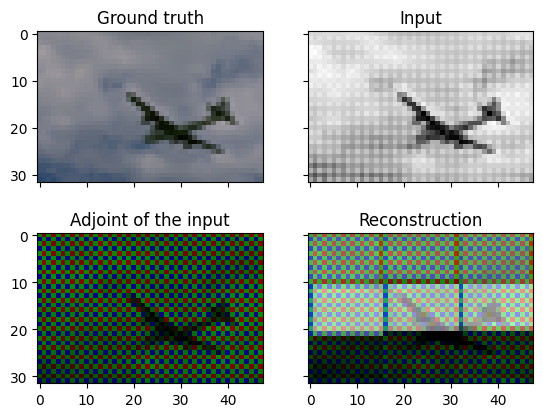

In [15]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

print(peak_signal_noise_ratio(x, x_hat))
axs[0, 0].imshow(x)
axs[0, 0].set_title('Ground truth')
axs[0, 1].imshow(y.cpu(), cmap='gray')
axs[0, 1].set_title('Input')
axs[1, 0].imshow(OP.adjoint(OP.direct(x)))
axs[1, 0].set_title('Adjoint of the input')
axs[1, 1].imshow(x_hat)
axs[1, 1].set_title('Reconstruction')